In [1]:
import os
import random
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split


# ---- CONFIG ----
ROOT = "/Users/ishabhansali/Downloads/resnet_project/cleaned"
TRAIN_DIR = os.path.join(ROOT, "Training")
TEST_DIR = os.path.join(ROOT, "Testing")
NUM_CLIENTS = 4
LOCAL_TEST_FRAC = 0.2
SEED = 77
ALPHA = 0.1  #non-IID

def set_seed(s=SEED):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

# ---- PATH CHECKS ----
if not os.path.exists(ROOT):
    raise FileNotFoundError(f"ROOT folder not found: {ROOT}")
if not os.path.exists(TRAIN_DIR):
    raise FileNotFoundError(f"Training directory not found: {TRAIN_DIR}")
if not os.path.exists(TEST_DIR):
    raise FileNotFoundError(f"Testing directory not found: {TEST_DIR}")

# ---- TRANSFORM AND LOAD ----
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=transform)
print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# ---- MODERATE NON-IID PARTITION (DIRICHLET) ----
labels = np.array([sample[1] for sample in train_dataset])
num_classes = len(train_dataset.classes)
class_indices = [np.where(labels == i)[0] for i in range(num_classes)]

client_indices = [[] for _ in range(NUM_CLIENTS)]
np.random.seed(SEED)

for c, idxs in enumerate(class_indices):
    # Sample proportions for each client using Dirichlet
    proportions = np.random.dirichlet(np.repeat(ALPHA, NUM_CLIENTS))
    # Adjust for rounding errors
    proportions = (np.cumsum(proportions) * len(idxs)).astype(int)[:-1]
    split_idxs = np.split(np.random.permutation(idxs), proportions)
    for client, idx in enumerate(split_idxs):
        client_indices[client].extend(idx)

# Shuffle indices for each client, then create subsets
client_subsets = []
for indices in client_indices:
    indices = np.array(indices)
    np.random.shuffle(indices)
    subset = torch.utils.data.Subset(train_dataset, indices.tolist())
    client_subsets.append(subset)
    print(f"Client {len(client_subsets)-1} train samples: {len(subset)}")

# ---- TEST SPLIT FOR EACH CLIENT ----
client_data = []
for c in client_subsets:
    n_test = int(len(c) * LOCAL_TEST_FRAC)
    n_train = len(c) - n_test
    tr, te = random_split(c, [n_train, n_test], generator=torch.Generator().manual_seed(SEED))
    client_data.append((tr, te))
    print(f"Client train: {n_train}, test: {n_test}")

# ---- CLASS BREAKDOWN FOR EACH CLIENT ----
class_names = train_dataset.classes
for idx, (client_train, _) in enumerate(client_data):
    labels = [client_train[i][1] for i in range(len(client_train))]
    counts = {class_name: labels.count(i) for i, class_name in enumerate(class_names)}
    print(f"Client {idx}:")
    for class_name in class_names:
        print(f"  {class_name}: {counts[class_name]} samples")
    print("-" * 30)
for idx, (client_train, client_test) in enumerate(client_data):
    # Train split breakdown
    train_labels = [client_train[i][1] for i in range(len(client_train))]
    train_counts = {class_name: train_labels.count(i) for i, class_name in enumerate(class_names)}

    # Test split breakdown
    test_labels = [client_test[i][1] for i in range(len(client_test))]
    test_counts = {class_name: test_labels.count(i) for i, class_name in enumerate(class_names)}

    print(f"Client {idx}:")
    print("  Training set:")
    for class_name in class_names:
        print(f"    {class_name}: {train_counts[class_name]} samples")
    print("  Testing set:")
    for class_name in class_names:
        print(f"    {class_name}: {test_counts[class_name]} samples")
    print("-" * 30)



Train samples: 5712, Test samples: 1311
Client 0 train samples: 2278
Client 1 train samples: 670
Client 2 train samples: 1173
Client 3 train samples: 1591
Client train: 1823, test: 455
Client train: 536, test: 134
Client train: 939, test: 234
Client train: 1273, test: 318
Client 0:
  glioma: 926 samples
  meningioma: 53 samples
  notumor: 0 samples
  pituitary: 844 samples
------------------------------
Client 1:
  glioma: 125 samples
  meningioma: 411 samples
  notumor: 0 samples
  pituitary: 0 samples
------------------------------
Client 2:
  glioma: 0 samples
  meningioma: 609 samples
  notumor: 7 samples
  pituitary: 323 samples
------------------------------
Client 3:
  glioma: 1 samples
  meningioma: 1 samples
  notumor: 1270 samples
  pituitary: 1 samples
------------------------------
Client 0:
  Training set:
    glioma: 926 samples
    meningioma: 53 samples
    notumor: 0 samples
    pituitary: 844 samples
  Testing set:
    glioma: 238 samples
    meningioma: 12 samples
  

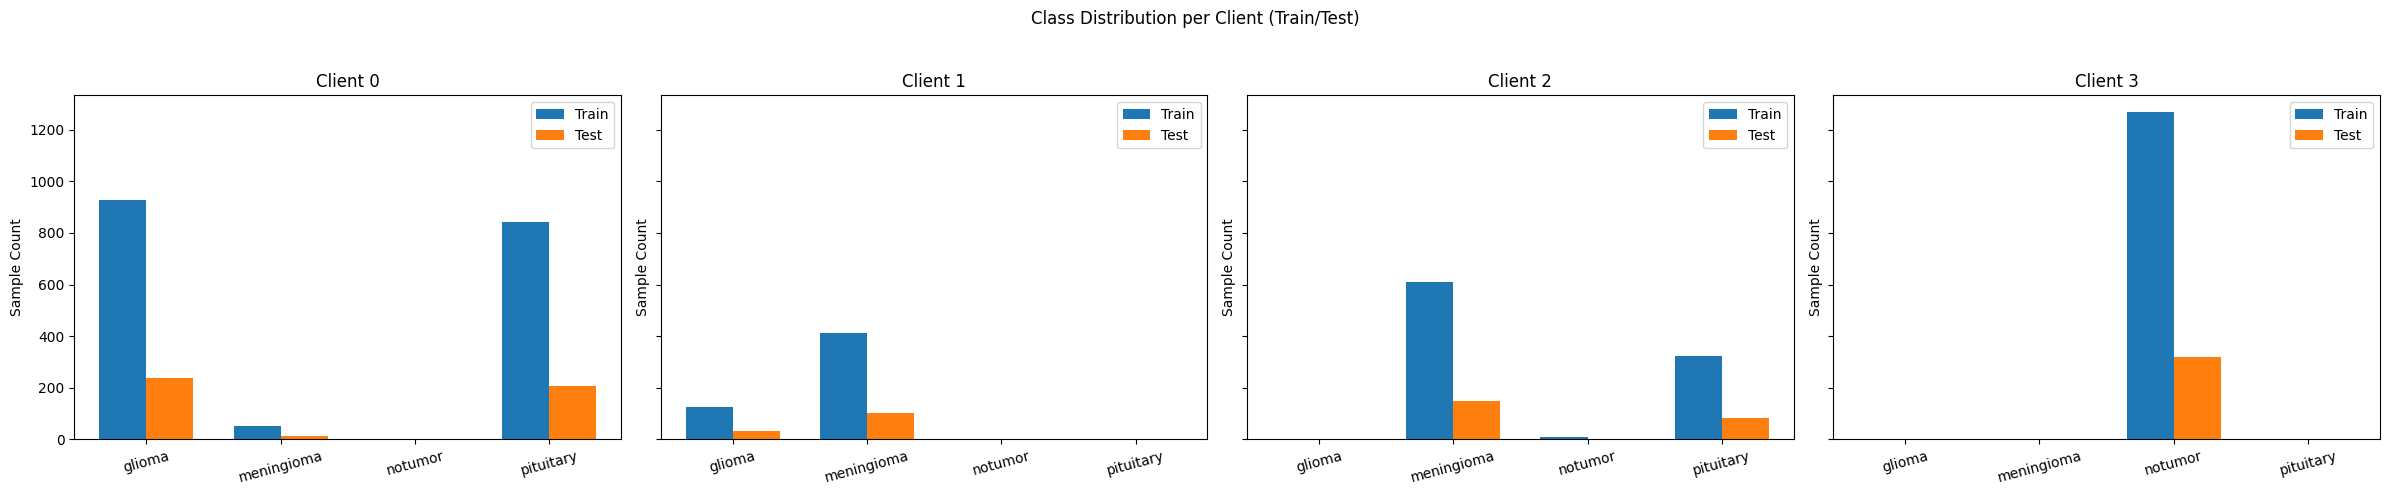

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# ---- PREPARE DATA FOR PLOTTING ----
client_train_counts = []
client_test_counts = []

for idx, (client_train, client_test) in enumerate(client_data):
    train_labels = [client_train[i][1] for i in range(len(client_train))]
    test_labels = [client_test[i][1] for i in range(len(client_test))]
    train_counts = [train_labels.count(i) for i in range(len(class_names))]
    test_counts = [test_labels.count(i) for i in range(len(class_names))]
    client_train_counts.append(train_counts)
    client_test_counts.append(test_counts)

client_train_counts = np.array(client_train_counts)
client_test_counts = np.array(client_test_counts)

# ---- GROUPED BAR CHART FOR EACH CLIENT ----
num_classes = len(class_names)
num_clients = len(client_data)
x = np.arange(num_classes)  # the label locations

fig, axs = plt.subplots(1, num_clients, figsize=(6 * num_clients, 5), sharey=True)
# Each subplot is for one client
for idx in range(num_clients):
    width = 0.35
    axs[idx].bar(x - width/2, client_train_counts[idx], width, label='Train', color='tab:blue')
    axs[idx].bar(x + width/2, client_test_counts[idx], width, label='Test', color='tab:orange')
    axs[idx].set_xticks(x)
    axs[idx].set_xticklabels(class_names, rotation=15)
    axs[idx].set_ylabel('Sample Count')
    axs[idx].set_title(f'Client {idx}')
    axs[idx].legend()

plt.suptitle('Class Distribution per Client (Train/Test)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


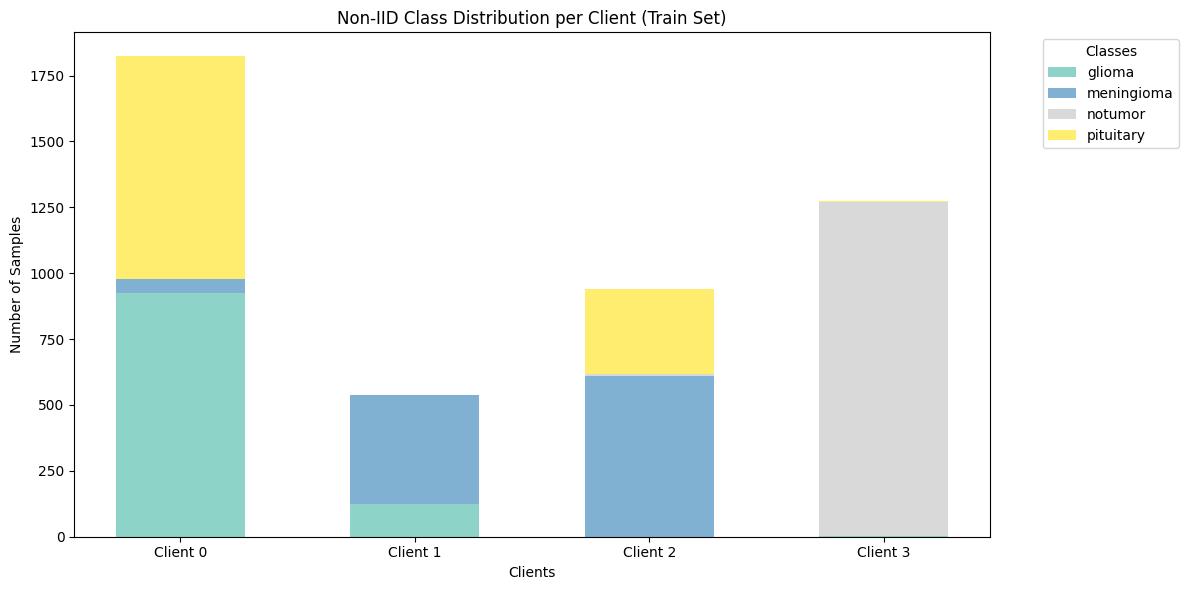

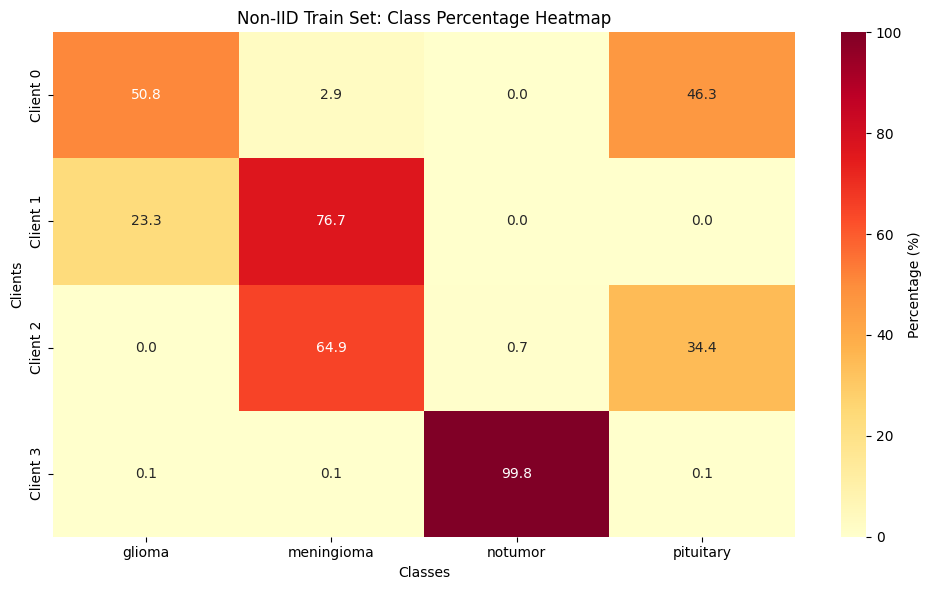

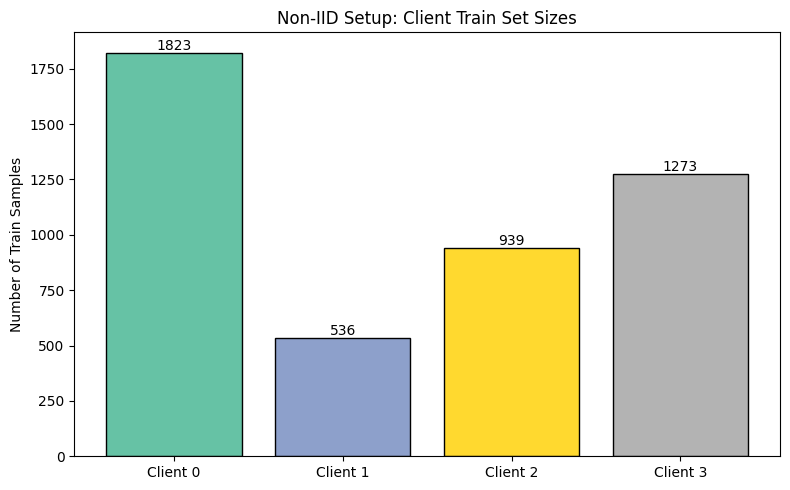

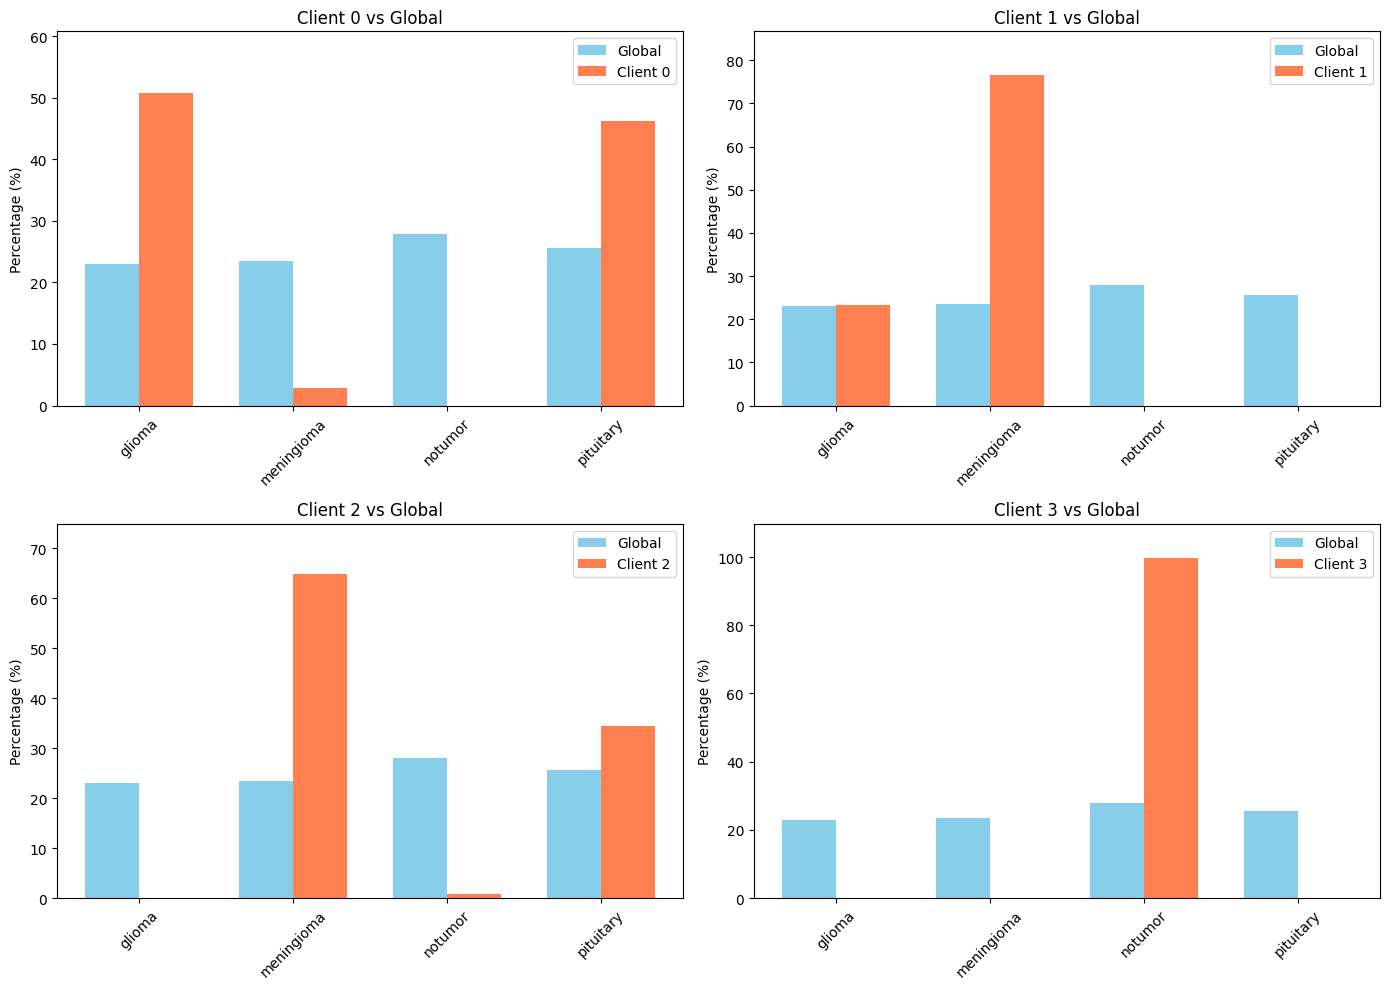


NON-IID DATA DISTRIBUTION SUMMARY (Train)

Client 0: 1823 samples
  glioma: 926 (50.8%)
  meningioma: 53 (2.9%)
  notumor: 0 (0.0%)
  pituitary: 844 (46.3%)

Client 1: 536 samples
  glioma: 125 (23.3%)
  meningioma: 411 (76.7%)
  notumor: 0 (0.0%)
  pituitary: 0 (0.0%)

Client 2: 939 samples
  glioma: 0 (0.0%)
  meningioma: 609 (64.9%)
  notumor: 7 (0.7%)
  pituitary: 323 (34.4%)

Client 3: 1273 samples
  glioma: 1 (0.1%)
  meningioma: 1 (0.1%)
  notumor: 1270 (99.8%)
  pituitary: 1 (0.1%)

Global Distribution (Train Set):
  glioma: 1052 (23.0%)
  meningioma: 1074 (23.5%)
  notumor: 1277 (27.9%)
  pituitary: 1168 (25.6%)


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict

# ----- 1. Collect train set class counts for each client -----
client_class_dist = []
for client_train, _ in client_data:  # only train split
    labels = [client_train[i][1] for i in range(len(client_train))]
    counts = [labels.count(i) for i in range(len(class_names))]
    client_class_dist.append(counts)

num_clients = len(client_class_dist)
num_classes = len(class_names)

# ----- 2. Stacked bar chart: class samples per client -----
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(num_clients)
bottom = np.zeros(num_clients)
colors = plt.cm.Set3(np.linspace(0, 1, num_classes))

for class_idx in range(num_classes):
    values = [client_class_dist[cidx][class_idx] for cidx in range(num_clients)]
    ax.bar(x, values, bottom=bottom, width=0.55, color=colors[class_idx], label=class_names[class_idx])
    bottom += np.array(values)
ax.set_xticks(x)
ax.set_xticklabels([f"Client {i}" for i in range(num_clients)])
ax.set_ylabel("Number of Samples")
ax.set_xlabel("Clients")
ax.set_title("Non-IID Class Distribution per Client (Train Set)")
ax.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ----- 3. Heatmap: class percentage per client -----
heatmap_data = []
for counts in client_class_dist:
    total = sum(counts)
    row = [100 * c / total if total > 0 else 0 for c in counts]
    heatmap_data.append(row)
heatmap_data = np.array(heatmap_data)

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': 'Percentage (%)'},
            xticklabels=class_names, yticklabels=[f"Client {i}" for i in range(num_clients)], ax=ax, vmin=0, vmax=100)
ax.set_title("Non-IID Train Set: Class Percentage Heatmap")
ax.set_xlabel("Classes")
ax.set_ylabel("Clients")
plt.tight_layout()
plt.show()

# ----- 4. Bar chart: client train set sizes -----
client_sizes = [sum(counts) for counts in client_class_dist]
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar([f"Client {i}" for i in range(num_clients)], client_sizes, color=plt.cm.Set2(np.linspace(0,1,num_clients)), edgecolor='black')
ax.set_ylabel("Number of Train Samples")
ax.set_title("Non-IID Setup: Client Train Set Sizes")
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# ----- 5. Comparison: global distribution vs client -----
global_counts = [0 for _ in range(num_classes)]
for client_train, _ in client_data:
    labels = [client_train[i][1] for i in range(len(client_train))]
    for i in labels:
        global_counts[i] += 1
global_total = sum(global_counts)
global_percentages = [100 * c / global_total for c in global_counts]

fig, axes = plt.subplots(2, (num_clients+1)//2, figsize=(14, 10))
axes = axes.flatten()
for idx in range(num_clients):
    client_total = sum(client_class_dist[idx])
    client_percentages = [100 * n / client_total if client_total > 0 else 0 for n in client_class_dist[idx]]
    x_pos = np.arange(num_classes)
    width = 0.35
    axes[idx].bar(x_pos - width/2, global_percentages, width, label='Global', color='skyblue')
    axes[idx].bar(x_pos + width/2, client_percentages, width, label=f'Client {idx}', color='coral')
    axes[idx].set_title(f"Client {idx} vs Global")
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(class_names, rotation=45)
    axes[idx].set_ylabel("Percentage (%)")
    axes[idx].legend()
    axes[idx].set_ylim([0, max(global_percentages + client_percentages) + 10])
plt.tight_layout()
plt.show()

# ----- 6. Summary statistics -----
print("\n" + "="*50)
print("NON-IID DATA DISTRIBUTION SUMMARY (Train)")
print("="*50)
for idx, counts in enumerate(client_class_dist):
    client_total = sum(counts)
    print(f"\nClient {idx}: {client_total} samples")
    for class_idx, class_name in enumerate(class_names):
        pct = 100 * counts[class_idx] / client_total if client_total > 0 else 0
        print(f"  {class_name}: {counts[class_idx]} ({pct:.1f}%)")

print("\n" + "="*50)
print("Global Distribution (Train Set):")
print("="*50)
for class_idx, class_name in enumerate(class_names):
    pct = 100 * global_counts[class_idx] / global_total if global_total > 0 else 0
    print(f"  {class_name}: {global_counts[class_idx]} ({pct:.1f}%)")
print("="*50)


In [5]:
import numpy as np
from scipy.spatial.distance import jensenshannon

# ----- 1. Prepare class distributions -----

# Get number of classes
num_classes = len(train_dataset.classes)

# Extract class distributions for each client
client_distributions = []
for k in range(NUM_CLIENTS):
    idxs = client_indices[k]
    counts = np.zeros(num_classes)
    for i in idxs:
        class_idx = train_dataset.samples[i][1]  # (filename, class_idx)
        counts[class_idx] += 1
    # Normalize to probabilities
    if counts.sum() > 0:
        prob_vec = counts / counts.sum()
    else:
        prob_vec = counts
    client_distributions.append(prob_vec)

# ----- 2. Compute global class distribution -----
global_counts = np.zeros(num_classes)
for sample in train_dataset.samples:
    class_idx = sample[1]
    global_counts[class_idx] += 1
global_dist = global_counts / global_counts.sum()

print("Global Distribution:", global_dist)
print("Classes:", train_dataset.classes)

# ----- 3. Compute Jensen-Shannon Divergence (JS Divergence) -----
print("\n" + "="*70)
print("JENSEN-SHANNON DIVERGENCE (Client vs Global)")
print("="*70)
print("Range: 0 (identical) to 1 (completely different)\n")

js_divergences = []
for k, client_dist in enumerate(client_distributions):
    js_div = jensenshannon(global_dist, client_dist)
    js_divergences.append(js_div)
    print(f"Client {k}: JS Divergence = {js_div:.4f}")

avg_js = np.mean(js_divergences)
print(f"\nAverage JS Divergence: {avg_js:.4f}")


Global Distribution: [0.23126751 0.23441877 0.27923669 0.25507703]
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']

JENSEN-SHANNON DIVERGENCE (Client vs Global)
Range: 0 (identical) to 1 (completely different)

Client 0: JS Divergence = 0.4298
Client 1: JS Divergence = 0.5097
Client 2: JS Divergence = 0.4672
Client 3: JS Divergence = 0.5926

Average JS Divergence: 0.4998


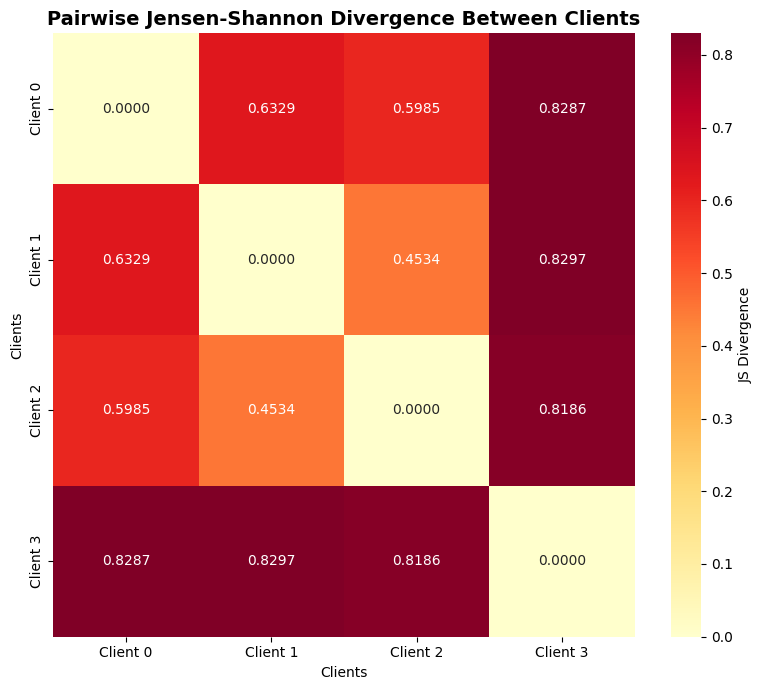

In [6]:
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
import seaborn as sns

# ----- 1. Prepare client class probability distributions -----
num_classes = len(train_dataset.classes)
client_distributions = []
for k in range(NUM_CLIENTS):
    idxs = client_indices[k]
    counts = np.zeros(num_classes)
    for i in idxs:
        class_idx = train_dataset.samples[i][1]
        counts[class_idx] += 1
    prob_vec = counts / counts.sum() if counts.sum() > 0 else counts
    client_distributions.append(prob_vec)

# ----- 2. Compute pairwise JS divergence matrix -----
pairwise_js = np.zeros((NUM_CLIENTS, NUM_CLIENTS))
for i in range(NUM_CLIENTS):
    for j in range(NUM_CLIENTS):
        pairwise_js[i, j] = jensenshannon(client_distributions[i], client_distributions[j])

# ----- 3. Plot pairwise JS divergence heatmap -----
plt.figure(figsize=(8, 7))
sns.heatmap(pairwise_js, annot=True, fmt='.4f', cmap='YlOrRd',
            xticklabels=[f'Client {i}' for i in range(NUM_CLIENTS)],
            yticklabels=[f'Client {i}' for i in range(NUM_CLIENTS)],
            cbar_kws={'label': 'JS Divergence'})
plt.title('Pairwise Jensen-Shannon Divergence Between Clients', fontsize=14, fontweight='bold')
plt.xlabel('Clients')
plt.ylabel('Clients')
plt.tight_layout()
plt.show()


In [14]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device:", DEVICE)


CUDA available: False
Device: cpu


In [15]:
import torch
print("MPS available:", torch.backends.mps.is_available())


MPS available: True


In [ ]:
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Subset

# ============================================================
#                    DEVICE SELECTION (MAC FIX)
# ============================================================
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("🚀 Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("🚀 Using NVIDIA GPU (CUDA)")
else:
    DEVICE = torch.device("cpu")
    print("🖥️ Using CPU (No GPU available)")

# ============================================================
#                         CONFIG
# ============================================================
SEED = 77
NUM_ROUNDS = 20
LOCAL_EPOCHS = 2
LR = 1e-4
BATCH_SIZE = 32
NUM_CLIENTS = len(client_indices)
NUM_CLASSES = len(train_dataset.classes)

# ============================================================
#                    REPRODUCIBILITY
# ============================================================
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ============================================================
#                   CLIENT LOADERS (IN-MEMORY)
# ============================================================
client_loaders = {}
for k in range(NUM_CLIENTS):
    train_subset = Subset(train_dataset, client_indices[k])
    client_loaders[k] = DataLoader(
        train_subset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0
    )

# Holdout/test loader (10% random split)
holdout_indices = np.random.choice(len(train_dataset), int(0.1 * len(train_dataset)), replace=False)
holdout_loader = DataLoader(
    Subset(train_dataset, holdout_indices),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

# ============================================================
#                        MODEL
# ============================================================
def create_resnet18(num_classes):
    model = models.resnet18(weights=None)
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model


crit_ce = nn.CrossEntropyLoss()

# ============================================================
#                   TRAINING FUNCTIONS
# ============================================================
def train_one_epoch(model, loader, device, optimizer):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        logits = model(x)
        loss = crit_ce(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return {"loss": total_loss/max(total,1), "acc": total_correct/max(total,1)}

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = crit_ce(logits, y)

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return {"loss": total_loss/max(total,1), "acc": total_correct/max(total,1)}

# ============================================================
#                  INITIALIZE GLOBAL MODEL
# ============================================================
global_model = create_resnet18(NUM_CLASSES).to(DEVICE)

best_global_acc = -1.0
best_global_state = None

metrics_history = {"round": [], "holdout": [], "clients": {k: [] for k in range(NUM_CLIENTS)}}

# ============================================================
#                     FEDAVG MAIN LOOP
# ============================================================
for rnd in range(NUM_ROUNDS):
    print(f"\n🔁 -------- Round {rnd+1}/{NUM_ROUNDS} --------")
    local_states = []

    # ----- LOCAL TRAINING -----
    for k in range(NUM_CLIENTS):
        local_model = copy.deepcopy(global_model).to(DEVICE)
        optimizer = optim.Adam(local_model.parameters(), lr=LR)

        for ep in range(LOCAL_EPOCHS):
            train_one_epoch(local_model, client_loaders[k], DEVICE, optimizer)

        # Save local model weights
        local_states.append({key: val.cpu() for key, val in local_model.state_dict().items()})

        # Evaluate locally
        client_metric = evaluate(local_model, client_loaders[k], DEVICE)
        metrics_history["clients"][k].append(client_metric)
        print(f"  Client {k} | Acc: {client_metric['acc']:.4f}")

    # ----- FEDERATED AVERAGING -----
    new_global_state = {}
    for key in global_model.state_dict().keys():
        stacked = torch.stack([state[key] for state in local_states], dim=0)

        if stacked.dtype.is_floating_point:
            new_global_state[key] = stacked.mean(dim=0)
        else:
            new_global_state[key] = stacked[0]

    global_model.load_state_dict(new_global_state)

    # ----- GLOBAL EVALUATION -----
    holdout_metric = evaluate(global_model, holdout_loader, DEVICE)
    metrics_history["round"].append(rnd+1)
    metrics_history["holdout"].append(holdout_metric)

    print(f"🌐 Global Model | Loss: {holdout_metric['loss']:.4f} | Acc: {holdout_metric['acc']:.4f}")

    # ----- SAVE BEST MODEL -----
    if holdout_metric['acc'] > best_global_acc:
        best_global_acc = holdout_metric['acc']
        best_global_state = copy.deepcopy(global_model.state_dict())
        print(f"💾 New Best Model Saved! Acc = {best_global_acc:.4f}")

# ============================================================
#                 SAVE BEST GLOBAL MODEL
# ============================================================
if best_global_state is not None:
    torch.save(best_global_state, "best_global_model.pth")
    print(f"\n✅ Best global model saved to best_global_model.pth (Acc = {best_global_acc:.4f})")
else:
    print("\n⚠️ No improvement — no model saved.")


🚀 Using Apple Silicon GPU (MPS)

🔁 -------- Round 1/20 --------
  Client 0 | Acc: 0.5536
  Client 1 | Acc: 0.8224
  Client 2 | Acc: 0.6633
  Client 3 | Acc: 0.9981
🌐 Global Model | Loss: 1.5880 | Acc: 0.2504
💾 New Best Model Saved! Acc = 0.2504

🔁 -------- Round 2/20 --------
  Client 0 | Acc: 0.9034
  Client 1 | Acc: 0.9343
  Client 2 | Acc: 0.9361
  Client 3 | Acc: 0.9981
🌐 Global Model | Loss: 1.3686 | Acc: 0.3468
💾 New Best Model Saved! Acc = 0.3468

🔁 -------- Round 3/20 --------
  Client 0 | Acc: 0.9820
  Client 1 | Acc: 0.9343
  Client 2 | Acc: 0.7596
  Client 3 | Acc: 0.9981
🌐 Global Model | Loss: 1.3844 | Acc: 0.2872

🔁 -------- Round 4/20 --------
  Client 0 | Acc: 0.5421
  Client 1 | Acc: 0.9881
  Client 2 | Acc: 0.8235
  Client 3 | Acc: 0.9981
🌐 Global Model | Loss: 1.3376 | Acc: 0.4063
💾 New Best Model Saved! Acc = 0.4063

🔁 -------- Round 5/20 --------
  Client 0 | Acc: 0.9899
  Client 1 | Acc: 0.9164
  Client 2 | Acc: 0.7937
  Client 3 | Acc: 0.9981
🌐 Global Model | Loss


📊 BEST MODEL METRICS ON HOLDOUT SET
Accuracy:  0.5587
Precision: 0.6985
Recall:    0.5427
F1-score:  0.5108


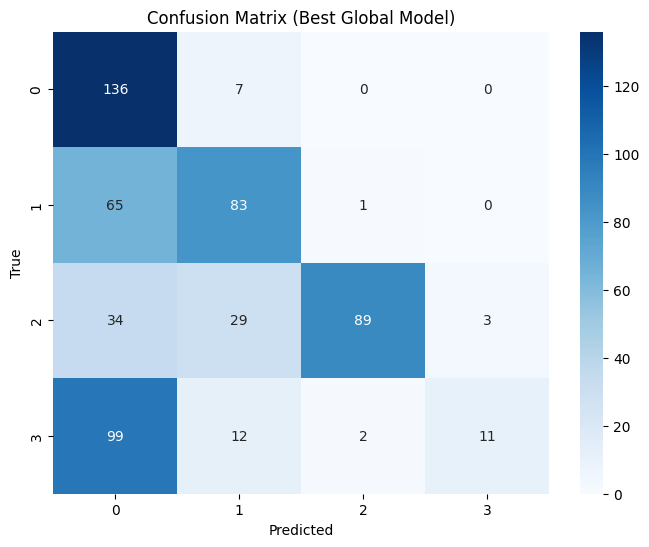

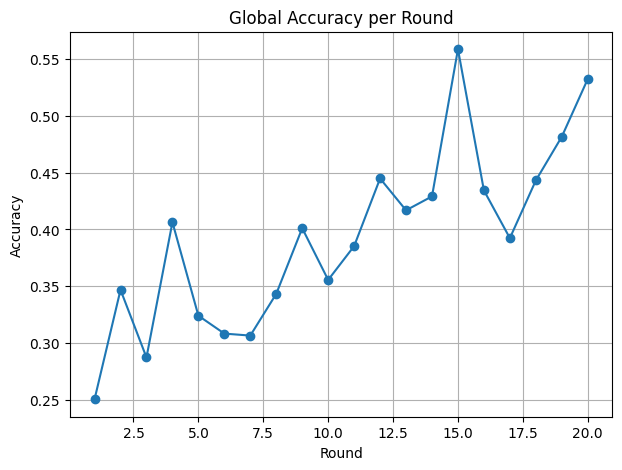

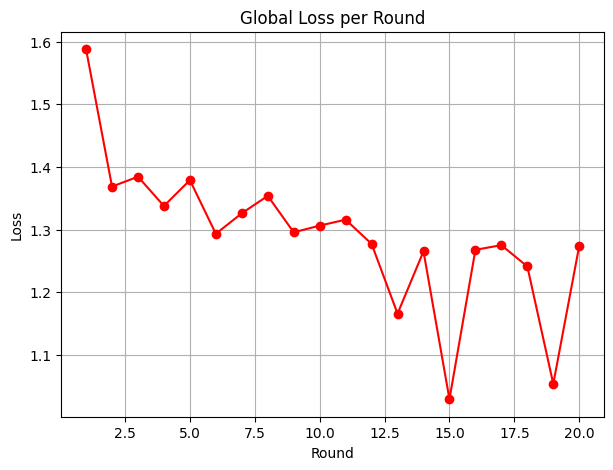

In [17]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np

# ============================================================
#          LOAD BEST MODEL + EVALUATE ON HOLDOUT
# ============================================================
best_model = create_resnet18(NUM_CLASSES)
best_model.load_state_dict(torch.load("best_global_model.pth"))
best_model.to(DEVICE)
best_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in holdout_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = best_model(x)
        preds = logits.argmax(1)

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# ---------- METRICS ----------
acc = (all_preds == all_labels).mean()
prec = precision_score(all_labels, all_preds, average="macro")
rec = recall_score(all_labels, all_preds, average="macro")
f1 = f1_score(all_labels, all_preds, average="macro")

print("\n📊 BEST MODEL METRICS ON HOLDOUT SET")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")

# ============================================================
#                     CONFUSION MATRIX
# ============================================================
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Best Global Model)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ============================================================
#       PLOT GLOBAL ACCURACY & LOSS OVER TRAINING ROUNDS
# ============================================================
rounds = metrics_history["round"]
accs = [h["acc"] for h in metrics_history["holdout"]]
losses = [h["loss"] for h in metrics_history["holdout"]]

# ---------- Accuracy Plot ----------
plt.figure(figsize=(7,5))
plt.plot(rounds, accs, marker='o')
plt.title("Global Accuracy per Round")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# ---------- Loss Plot ----------
plt.figure(figsize=(7,5))
plt.plot(rounds, losses, marker='o', color="red")
plt.title("Global Loss per Round")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [20]:
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Subset

# ============================================================
#                    DEVICE SELECTION (MAC FIX)
# ============================================================
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("🚀 Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("🚀 Using NVIDIA GPU (CUDA)")
else:
    DEVICE = torch.device("cpu")
    print("🖥️ Using CPU (No GPU available)")

# ============================================================
#                         CONFIG
# ============================================================
SEED = 77
NUM_ROUNDS = 20
LOCAL_EPOCHS = 2
LR = 1e-4
FEDPROX_MU = 1e-3       # recommended starting value
BATCH_SIZE = 32
NUM_CLIENTS = len(client_indices)
NUM_CLASSES = len(train_dataset.classes)

# ============================================================
#                    REPRODUCIBILITY
# ============================================================
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ============================================================
#                   CLIENT LOADERS (IN-MEMORY)
# ============================================================
client_loaders = {}
for k in range(NUM_CLIENTS):
    train_subset = Subset(train_dataset, client_indices[k])
    client_loaders[k] = DataLoader(
        train_subset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0
    )

# Holdout/test loader (10% random split)
holdout_indices = np.random.choice(len(train_dataset), int(0.1 * len(train_dataset)), replace=False)
holdout_loader = DataLoader(
    Subset(train_dataset, holdout_indices),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

# ============================================================
#                        MODEL
# ============================================================
def create_resnet18(num_classes):
    model = models.resnet18(weights=None)
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model

crit_ce = nn.CrossEntropyLoss()

# ============================================================
#            EVALUATION FUNCTION (same as FedAvg)
# ============================================================
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = crit_ce(logits, y)

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return {"loss": total_loss / max(total, 1), "acc": total_correct / max(total, 1)}

# ============================================================
#               FEDPROX LOCAL TRAIN FUNCTION
# ============================================================
def train_fedprox_epoch(model, loader, device, optimizer, global_params, mu):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        logits = model(x)
        ce_loss = crit_ce(logits, y)

        # FedProx proximal penalty
        prox_term = 0.0
        for name, param in model.named_parameters():
            prox_term += ((param - global_params[name]) ** 2).sum()

        loss = ce_loss + (mu / 2.0) * prox_term
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return {"loss": total_loss / max(total, 1), "acc": total_correct / max(total, 1)}

# ============================================================
#             INITIALIZE GLOBAL MODEL FOR FEDPROX
# ============================================================
global_model = create_resnet18(NUM_CLASSES).to(DEVICE)

best_global_acc = -1.0
best_global_state = None

metrics_history = {"round": [], "holdout": [], "clients": {k: [] for k in range(NUM_CLIENTS)}}

# ============================================================
#                     FEDPROX MAIN LOOP
# ============================================================
for rnd in range(NUM_ROUNDS):
    print(f"\n🔁 -------- FedProx Round {rnd+1}/{NUM_ROUNDS} --------")
    local_states = []

    # Cache global parameters (for proximal term)
    global_params = {
        name: p.detach().clone().to(DEVICE)
        for name, p in global_model.named_parameters()
    }

    # ----- LOCAL TRAINING -----
    for k in range(NUM_CLIENTS):
        local_model = copy.deepcopy(global_model).to(DEVICE)
        optimizer = optim.Adam(local_model.parameters(), lr=LR)

        for ep in range(LOCAL_EPOCHS):
            train_metrics = train_fedprox_epoch(
                local_model,
                client_loaders[k],
                DEVICE,
                optimizer,
                global_params,
                mu=FEDPROX_MU
            )

        # Save local model weights
        local_states.append({key: val.cpu() for key, val in local_model.state_dict().items()})

        # Per-client evaluation (same as FedAvg)
        client_metric = evaluate(local_model, client_loaders[k], DEVICE)
        metrics_history["clients"][k].append(client_metric)
        print(f"  Client {k} | Acc: {client_metric['acc']:.4f}")

    # ----- FEDERATED AVERAGING (same as FedAvg) -----
    new_global_state = {}
    for key in global_model.state_dict().keys():
        stacked = torch.stack([state[key] for state in local_states], dim=0)

        if stacked.dtype.is_floating_point:
            new_global_state[key] = stacked.mean(dim=0)
        else:
            new_global_state[key] = stacked[0]

    global_model.load_state_dict(new_global_state)

    # ----- GLOBAL EVALUATION -----
    holdout_metric = evaluate(global_model, holdout_loader, DEVICE)
    metrics_history["round"].append(rnd+1)
    metrics_history["holdout"].append(holdout_metric)

    print(f"🌐 FedProx Global | Loss: {holdout_metric['loss']:.4f} | Acc: {holdout_metric['acc']:.4f}")

    # ----- SAVE BEST FEDPROX MODEL -----
    if holdout_metric['acc'] > best_global_acc:
        best_global_acc = holdout_metric['acc']
        best_global_state = copy.deepcopy(global_model.state_dict())
        print(f"💾 New Best FedProx Model Saved! Acc = {best_global_acc:.4f}")

# ============================================================
#                 SAVE BEST FEDPROX MODEL
# ============================================================
if best_global_state is not None:
    torch.save(best_global_state, "best_fedprox_model.pth")
    print(f"\n✅ Best FedProx model saved to best_fedprox_model.pth (Acc = {best_global_acc:.4f})")
else:
    print("\n⚠️ No improvement — no FedProx model saved.")


🚀 Using Apple Silicon GPU (MPS)

🔁 -------- FedProx Round 1/20 --------
  Client 0 | Acc: 0.5443
  Client 1 | Acc: 0.8224
  Client 2 | Acc: 0.6684
  Client 3 | Acc: 0.9981
🌐 FedProx Global | Loss: 1.5772 | Acc: 0.2504
💾 New Best FedProx Model Saved! Acc = 0.2504

🔁 -------- FedProx Round 2/20 --------
  Client 0 | Acc: 0.7581
  Client 1 | Acc: 0.9313
  Client 2 | Acc: 0.9650
  Client 3 | Acc: 0.9981
🌐 FedProx Global | Loss: 1.3587 | Acc: 0.3205
💾 New Best FedProx Model Saved! Acc = 0.3205

🔁 -------- FedProx Round 3/20 --------
  Client 0 | Acc: 0.9895
  Client 1 | Acc: 0.8478
  Client 2 | Acc: 0.7528
  Client 3 | Acc: 0.9981
🌐 FedProx Global | Loss: 1.3843 | Acc: 0.2942

🔁 -------- FedProx Round 4/20 --------
  Client 0 | Acc: 0.5698
  Client 1 | Acc: 0.9910
  Client 2 | Acc: 0.6607
  Client 3 | Acc: 0.9981
🌐 FedProx Global | Loss: 1.3878 | Acc: 0.3835
💾 New Best FedProx Model Saved! Acc = 0.3835

🔁 -------- FedProx Round 5/20 --------
  Client 0 | Acc: 0.9912
  Client 1 | Acc: 0.9672

In [21]:
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Subset

# ============================================================
#                    DEVICE SELECTION (MAC FIX)
# ============================================================
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("🚀 Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("🚀 Using NVIDIA GPU (CUDA)")
else:
    DEVICE = torch.device("cpu")
    print("🖥️ Using CPU (No GPU available)")

# ============================================================
#                         CONFIG
# ============================================================
SEED = 77
NUM_ROUNDS = 20
LOCAL_EPOCHS = 2
LR = 1e-4
FEDPROX_MU = 1e-4      # <<< change μ here anytime
BATCH_SIZE = 32
NUM_CLIENTS = len(client_indices)
NUM_CLASSES = len(train_dataset.classes)

# ============================================================
#                    REPRODUCIBILITY
# ============================================================
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ============================================================
#                   CLIENT LOADERS (IN-MEMORY)
# ============================================================
client_loaders = {}
for k in range(NUM_CLIENTS):
    train_subset = Subset(train_dataset, client_indices[k])
    client_loaders[k] = DataLoader(
        train_subset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0
    )

# Holdout/test loader (10% random split)
holdout_indices = np.random.choice(len(train_dataset), int(0.1 * len(train_dataset)), replace=False)
holdout_loader = DataLoader(
    Subset(train_dataset, holdout_indices),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

# ============================================================
#                        MODEL
# ============================================================
def create_resnet18(num_classes):
    model = models.resnet18(weights=None)
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model

crit_ce = nn.CrossEntropyLoss()

# ============================================================
#            EVALUATION FUNCTION
# ============================================================
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = crit_ce(logits, y)

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return {"loss": total_loss / max(total, 1), "acc": total_correct / max(total, 1)}

# ============================================================
#            FEDPROX LOCAL TRAIN FUNCTION
# ============================================================
def train_fedprox_epoch(model, loader, device, optimizer, global_params, mu):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        logits = model(x)
        ce_loss = crit_ce(logits, y)

        # -------- PROXIMAL TERM --------
        prox_term = 0.0
        for name, param in model.named_parameters():
            prox_term += ((param - global_params[name]) ** 2).sum()

        loss = ce_loss + (mu / 2.0) * prox_term
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return {"loss": total_loss / max(total, 1), "acc": total_correct / max(total, 1)}

# ============================================================
#            INITIALIZE GLOBAL MODEL
# ============================================================
global_model = create_resnet18(NUM_CLASSES).to(DEVICE)

best_global_acc = -1.0
best_global_state = None

metrics_history = {
    "round": [],
    "holdout": [],
    "clients": {k: [] for k in range(NUM_CLIENTS)}
}

# ============================================================
#                    FEDPROX MAIN LOOP
# ============================================================
for rnd in range(NUM_ROUNDS):
    print(f"\n🔁 -------- FedProx Round {rnd+1}/{NUM_ROUNDS} --------")
    local_states = []

    # Cache global parameters (required for FedProx)
    global_params = {
        name: p.detach().clone().to(DEVICE)
        for name, p in global_model.named_parameters()
    }

    # ----- LOCAL TRAINING -----
    for k in range(NUM_CLIENTS):
        local_model = copy.deepcopy(global_model).to(DEVICE)
        optimizer = optim.Adam(local_model.parameters(), lr=LR)

        for ep in range(LOCAL_EPOCHS):
            train_metrics = train_fedprox_epoch(
                local_model,
                client_loaders[k],
                DEVICE,
                optimizer,
                global_params,
                mu=FEDPROX_MU
            )

        # Save local model weights
        local_states.append({key: val.cpu() for key, val in local_model.state_dict().items()})

        # Evaluate on client's train split
        client_metric = evaluate(local_model, client_loaders[k], DEVICE)
        metrics_history["clients"][k].append(client_metric)
        print(f"  Client {k} | Acc: {client_metric['acc']:.4f}")

    # ----- FEDERATED AVERAGING -----
    new_global_state = {}
    for key in global_model.state_dict().keys():
        stacked = torch.stack([state[key] for state in local_states], dim=0)
        if stacked.dtype.is_floating_point:
            new_global_state[key] = stacked.mean(dim=0)
        else:
            new_global_state[key] = stacked[0]

    global_model.load_state_dict(new_global_state)

    # ----- GLOBAL EVALUATION -----
    holdout_metric = evaluate(global_model, holdout_loader, DEVICE)
    metrics_history["round"].append(rnd+1)
    metrics_history["holdout"].append(holdout_metric)

    print(f"🌐 FedProx Global | Loss: {holdout_metric['loss']:.4f} | Acc: {holdout_metric['acc']:.4f}")

    # ----- SAVE BEST FEDPROX MODEL -----
    if holdout_metric['acc'] > best_global_acc:
        best_global_acc = holdout_metric['acc']
        best_global_state = copy.deepcopy(global_model.state_dict())
        print(f"💾 New Best FedProx Model Saved! Acc = {best_global_acc:.4f}")

# ============================================================
#                 SAVE BEST FEDPROX MODEL
# ============================================================
if best_global_state is not None:
    torch.save(best_global_state, "best_fedprox_model_mu4.pth")
    print(f"\n✅ Best FedProx model saved to best_fedprox_model_mu4.pth (Acc = {best_global_acc:.4f})")
else:
    print("\n⚠️ No improvement — no FedProx model saved.")


🚀 Using Apple Silicon GPU (MPS)

🔁 -------- FedProx Round 1/20 --------
  Client 0 | Acc: 0.5882
  Client 1 | Acc: 0.8299
  Client 2 | Acc: 0.6616
  Client 3 | Acc: 0.9981
🌐 FedProx Global | Loss: 1.5950 | Acc: 0.2504
💾 New Best FedProx Model Saved! Acc = 0.2504

🔁 -------- FedProx Round 2/20 --------
  Client 0 | Acc: 0.9118
  Client 1 | Acc: 0.8881
  Client 2 | Acc: 0.9557
  Client 3 | Acc: 0.9981
🌐 FedProx Global | Loss: 1.3619 | Acc: 0.3152
💾 New Best FedProx Model Saved! Acc = 0.3152

🔁 -------- FedProx Round 3/20 --------
  Client 0 | Acc: 0.9368
  Client 1 | Acc: 0.9388
  Client 2 | Acc: 0.7519
  Client 3 | Acc: 0.9981
🌐 FedProx Global | Loss: 1.3649 | Acc: 0.3082

🔁 -------- FedProx Round 4/20 --------
  Client 0 | Acc: 0.5944
  Client 1 | Acc: 0.9328
  Client 2 | Acc: 0.6854
  Client 3 | Acc: 0.9981
🌐 FedProx Global | Loss: 1.3838 | Acc: 0.3905
💾 New Best FedProx Model Saved! Acc = 0.3905

🔁 -------- FedProx Round 5/20 --------
  Client 0 | Acc: 0.9925
  Client 1 | Acc: 0.9299

Loading: best_fedprox_model_mu4.pth

====== 📊 FINAL FEDPROX PERFORMANCE (μ = 1e-4) ======
Accuracy : 0.5377
Loss     : 1.0999
Precision: 0.6487
Recall   : 0.5196
F1 Score : 0.4691


<Figure size 600x600 with 0 Axes>

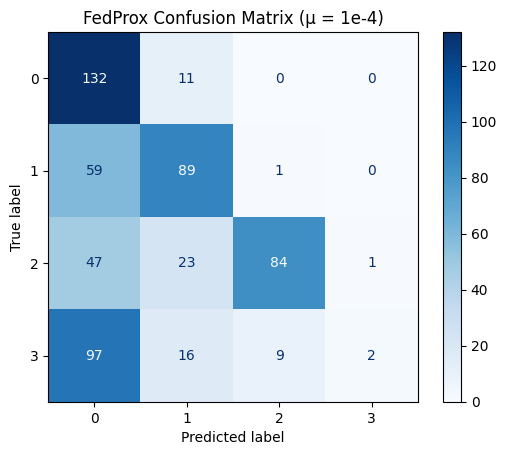

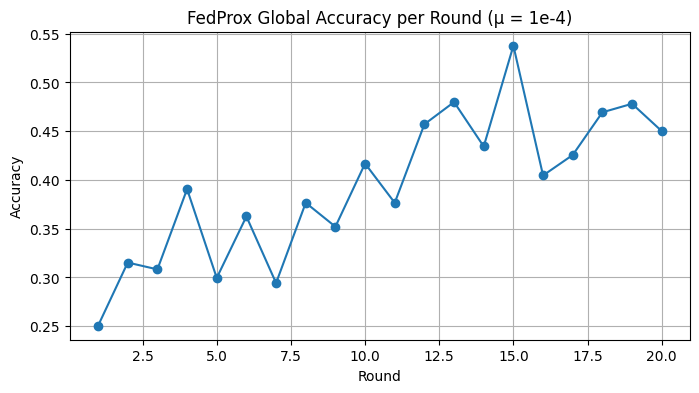

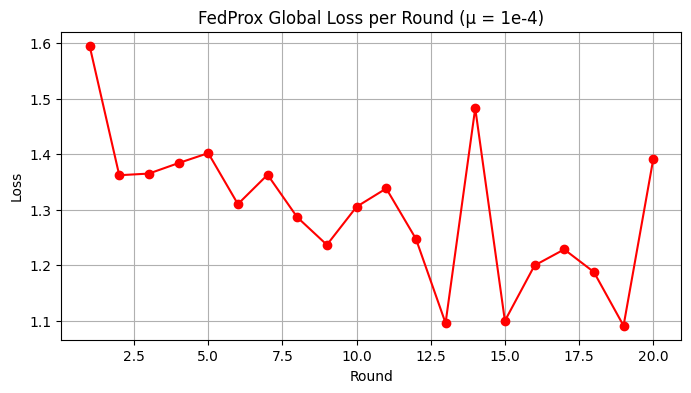

In [22]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import numpy as np

# -------------------------------------------------
# 1️⃣ Load Best FedProx Model
# -------------------------------------------------
best_model_path = "best_fedprox_model_mu4.pth"
print(f"Loading: {best_model_path}")
global_model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
global_model.to(DEVICE)
global_model.eval()

# -------------------------------------------------
# 2️⃣ Evaluate on Global Holdout Set (FULL METRICS)
# -------------------------------------------------
all_preds = []
all_labels = []
total_loss = 0
total = 0

crit_ce = nn.CrossEntropyLoss()

with torch.no_grad():
    for x, y in holdout_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        logits = global_model(x)
        loss = crit_ce(logits, y)
        
        total_loss += loss.item() * x.size(0)
        total += x.size(0)
        
        preds = logits.argmax(1)
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

acc = (all_preds == all_labels).mean()
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
loss = total_loss / total

print("\n====== 📊 FINAL FEDPROX PERFORMANCE (μ = 1e-4) ======")
print(f"Accuracy : {acc:.4f}")
print(f"Loss     : {loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("=====================================================")

# -------------------------------------------------
# 3️⃣ Confusion Matrix
# -------------------------------------------------
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("FedProx Confusion Matrix (μ = 1e-4)")
plt.show()

# -------------------------------------------------
# 4️⃣ Convergence Plot — Accuracy
# -------------------------------------------------
rounds = metrics_history["round"]
global_acc = [m["acc"] for m in metrics_history["holdout"]]

plt.figure(figsize=(8, 4))
plt.plot(rounds, global_acc, marker="o")
plt.title("FedProx Global Accuracy per Round (μ = 1e-4)")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# -------------------------------------------------
# 5️⃣ Convergence Plot — Loss
# -------------------------------------------------
global_loss = [m["loss"] for m in metrics_history["holdout"]]

plt.figure(figsize=(8, 4))
plt.plot(rounds, global_loss, marker="o", color='red')
plt.title("FedProx Global Loss per Round (μ = 1e-4)")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [25]:
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Subset

# ============================================================
#                    DEVICE SELECTION (MAC FIX)
# ============================================================
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("🚀 Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("🚀 Using NVIDIA GPU (CUDA)")
else:
    DEVICE = torch.device("cpu")
    print("🖥️ Using CPU (No GPU available)")

# ============================================================
#                         CONFIG
# ============================================================
SEED = 77
NUM_ROUNDS = 20
LOCAL_EPOCHS = 2
LR = 1e-4
FEDPROX_MU = 5e-4      # <<< change μ here anytime
BATCH_SIZE = 32
NUM_CLIENTS = len(client_indices)
NUM_CLASSES = len(train_dataset.classes)

# ============================================================
#                    REPRODUCIBILITY
# ============================================================
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ============================================================
#                   CLIENT LOADERS (IN-MEMORY)
# ============================================================
client_loaders = {}
for k in range(NUM_CLIENTS):
    train_subset = Subset(train_dataset, client_indices[k])
    client_loaders[k] = DataLoader(
        train_subset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0
    )

# Holdout/test loader (10% random split)
holdout_indices = np.random.choice(len(train_dataset), int(0.1 * len(train_dataset)), replace=False)
holdout_loader = DataLoader(
    Subset(train_dataset, holdout_indices),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

# ============================================================
#                        MODEL
# ============================================================
def create_resnet18(num_classes):
    model = models.resnet18(weights=None)
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model

crit_ce = nn.CrossEntropyLoss()

# ============================================================
#            EVALUATION FUNCTION
# ============================================================
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = crit_ce(logits, y)

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return {"loss": total_loss / max(total, 1), "acc": total_correct / max(total, 1)}

# ============================================================
#            FEDPROX LOCAL TRAIN FUNCTION
# ============================================================
def train_fedprox_epoch(model, loader, device, optimizer, global_params, mu):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        logits = model(x)
        ce_loss = crit_ce(logits, y)

        # -------- PROXIMAL TERM --------
        prox_term = 0.0
        for name, param in model.named_parameters():
            prox_term += ((param - global_params[name]) ** 2).sum()

        loss = ce_loss + (mu / 2.0) * prox_term
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return {"loss": total_loss / max(total, 1), "acc": total_correct / max(total, 1)}

# ============================================================
#            INITIALIZE GLOBAL MODEL
# ============================================================
global_model = create_resnet18(NUM_CLASSES).to(DEVICE)

best_global_acc = -1.0
best_global_state = None

metrics_history = {
    "round": [],
    "holdout": [],
    "clients": {k: [] for k in range(NUM_CLIENTS)}
}

# ============================================================
#                    FEDPROX MAIN LOOP
# ============================================================
for rnd in range(NUM_ROUNDS):
    print(f"\n🔁 -------- FedProx Round {rnd+1}/{NUM_ROUNDS} --------")
    local_states = []

    # Cache global parameters (required for FedProx)
    global_params = {
        name: p.detach().clone().to(DEVICE)
        for name, p in global_model.named_parameters()
    }

    # ----- LOCAL TRAINING -----
    for k in range(NUM_CLIENTS):
        local_model = copy.deepcopy(global_model).to(DEVICE)
        optimizer = optim.Adam(local_model.parameters(), lr=LR)

        for ep in range(LOCAL_EPOCHS):
            train_metrics = train_fedprox_epoch(
                local_model,
                client_loaders[k],
                DEVICE,
                optimizer,
                global_params,
                mu=FEDPROX_MU
            )

        # Save local model weights
        local_states.append({key: val.cpu() for key, val in local_model.state_dict().items()})

        # Evaluate on client's train split
        client_metric = evaluate(local_model, client_loaders[k], DEVICE)
        metrics_history["clients"][k].append(client_metric)
        print(f"  Client {k} | Acc: {client_metric['acc']:.4f}")

    # ----- FEDERATED AVERAGING -----
    new_global_state = {}
    for key in global_model.state_dict().keys():
        stacked = torch.stack([state[key] for state in local_states], dim=0)
        if stacked.dtype.is_floating_point:
            new_global_state[key] = stacked.mean(dim=0)
        else:
            new_global_state[key] = stacked[0]

    global_model.load_state_dict(new_global_state)

    # ----- GLOBAL EVALUATION -----
    holdout_metric = evaluate(global_model, holdout_loader, DEVICE)
    metrics_history["round"].append(rnd+1)
    metrics_history["holdout"].append(holdout_metric)

    print(f"🌐 FedProx Global | Loss: {holdout_metric['loss']:.4f} | Acc: {holdout_metric['acc']:.4f}")

    # ----- SAVE BEST FEDPROX MODEL -----
    if holdout_metric['acc'] > best_global_acc:
        best_global_acc = holdout_metric['acc']
        best_global_state = copy.deepcopy(global_model.state_dict())
        print(f"💾 New Best FedProx Model Saved! Acc = {best_global_acc:.4f}")

# ============================================================
#                 SAVE BEST FEDPROX MODEL
# ============================================================
if best_global_state is not None:
    torch.save(best_global_state, "best_fedprox_model_mu5.pth")
    print(f"\n✅ Best FedProx model saved to best_fedprox_model_mu5.pth (Acc = {best_global_acc:.4f})")
else:
    print("\n⚠️ No improvement — no FedProx model saved.")


🚀 Using Apple Silicon GPU (MPS)

🔁 -------- FedProx Round 1/20 --------
  Client 0 | Acc: 0.5869
  Client 1 | Acc: 0.8328
  Client 2 | Acc: 0.6650
  Client 3 | Acc: 0.9981
🌐 FedProx Global | Loss: 1.5891 | Acc: 0.2522
💾 New Best FedProx Model Saved! Acc = 0.2522

🔁 -------- FedProx Round 2/20 --------
  Client 0 | Acc: 0.9737
  Client 1 | Acc: 0.9313
  Client 2 | Acc: 0.9744
  Client 3 | Acc: 0.9981
🌐 FedProx Global | Loss: 1.3753 | Acc: 0.3625
💾 New Best FedProx Model Saved! Acc = 0.3625

🔁 -------- FedProx Round 3/20 --------
  Client 0 | Acc: 0.9785
  Client 1 | Acc: 0.7507
  Client 2 | Acc: 0.8389
  Client 3 | Acc: 0.9981
🌐 FedProx Global | Loss: 1.3460 | Acc: 0.3065

🔁 -------- FedProx Round 4/20 --------
  Client 0 | Acc: 0.5492
  Client 1 | Acc: 0.9463
  Client 2 | Acc: 0.7212
  Client 3 | Acc: 0.9981
🌐 FedProx Global | Loss: 1.3365 | Acc: 0.4028
💾 New Best FedProx Model Saved! Acc = 0.4028

🔁 -------- FedProx Round 5/20 --------
  Client 0 | Acc: 0.9969
  Client 1 | Acc: 0.9582

Loading: best_fedprox_model_mu5.pth

====== 📊 FINAL FEDPROX PERFORMANCE (μ = 5e-4) ======
Accuracy : 0.5692
Loss     : 1.0667
Precision: 0.7252
Recall   : 0.5524
F1 Score : 0.5270


<Figure size 600x600 with 0 Axes>

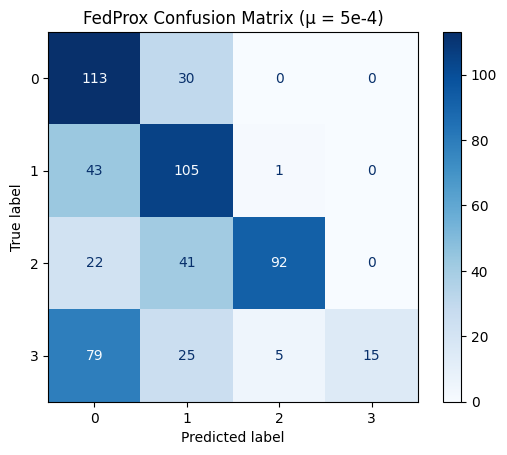

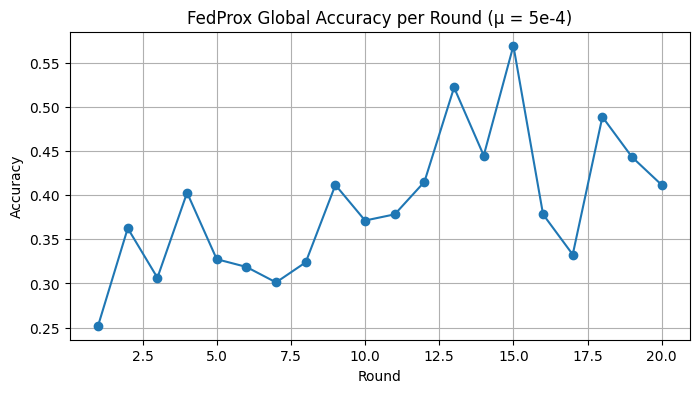

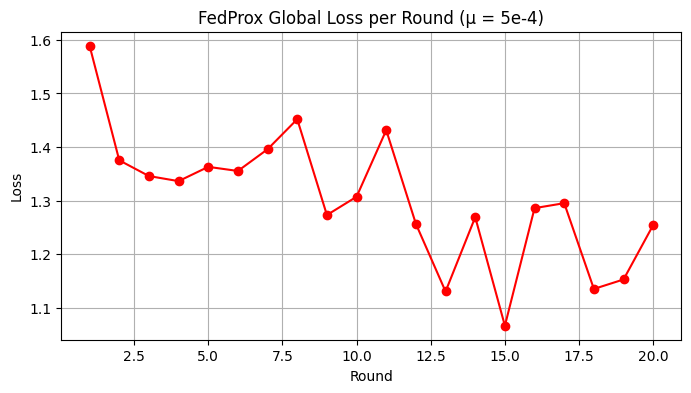

In [26]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import numpy as np

# -------------------------------------------------
# 1️⃣ Load Best FedProx Model (μ = 5e-4)
# -------------------------------------------------
best_model_path = "best_fedprox_model_mu5.pth"
print(f"Loading: {best_model_path}")

global_model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
global_model.to(DEVICE)
global_model.eval()

# -------------------------------------------------
# 2️⃣ Evaluate on Global Holdout Set (FULL METRICS)
# -------------------------------------------------
all_preds = []
all_labels = []
total_loss = 0
total = 0

crit_ce = nn.CrossEntropyLoss()

with torch.no_grad():
    for x, y in holdout_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        logits = global_model(x)
        loss = crit_ce(logits, y)
        
        total_loss += loss.item() * x.size(0)
        total += x.size(0)
        
        preds = logits.argmax(1)
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

acc = (all_preds == all_labels).mean()
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
loss = total_loss / total

print("\n====== 📊 FINAL FEDPROX PERFORMANCE (μ = 5e-4) ======")
print(f"Accuracy : {acc:.4f}")
print(f"Loss     : {loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("=====================================================")

# -------------------------------------------------
# 3️⃣ Confusion Matrix
# -------------------------------------------------
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("FedProx Confusion Matrix (μ = 5e-4)")
plt.show()

# -------------------------------------------------
# 4️⃣ Convergence Plot — Accuracy
# -------------------------------------------------
rounds = metrics_history["round"]
global_acc = [m["acc"] for m in metrics_history["holdout"]]

plt.figure(figsize=(8, 4))
plt.plot(rounds, global_acc, marker="o")
plt.title("FedProx Global Accuracy per Round (μ = 5e-4)")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

# -------------------------------------------------
# 5️⃣ Convergence Plot — Loss
# -------------------------------------------------
global_loss = [m["loss"] for m in metrics_history["holdout"]]

plt.figure(figsize=(8, 4))
plt.plot(rounds, global_loss, marker="o", color='red')
plt.title("FedProx Global Loss per Round (μ = 5e-4)")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


Loading FedAvg model...
Loading FedProx μ=5e-4 model...

========= FEDAVG (Best Model) =========
Acc       : 0.5587
Loss      : 1.0290
Precision : 0.6985
Recall    : 0.5427
F1        : 0.5108

====== FEDPROX (μ=5e-4 Best Model) ======
Acc       : 0.5692
Loss      : 1.0667
Precision : 0.7252
Recall    : 0.5524
F1        : 0.5270


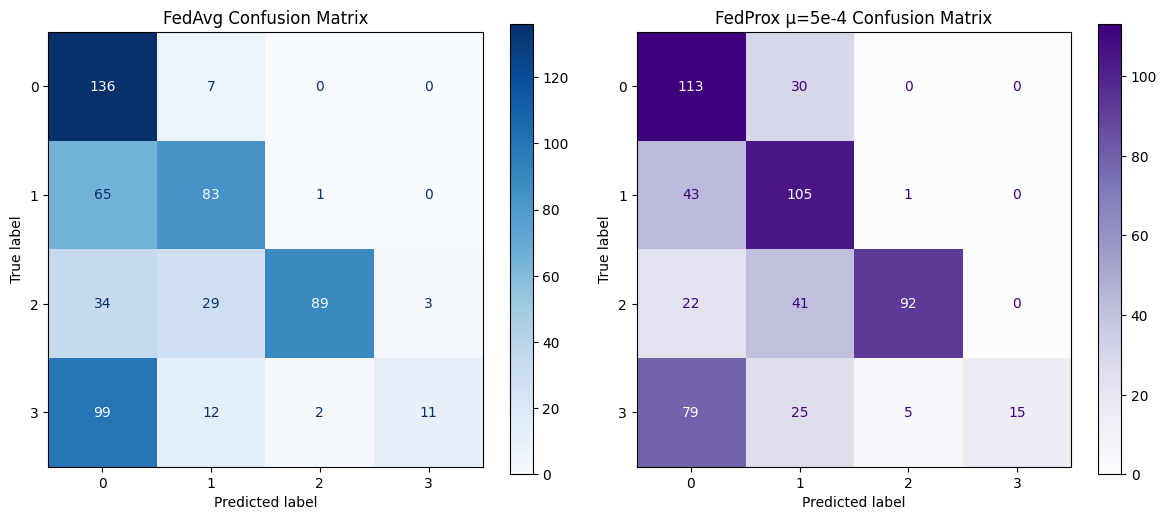

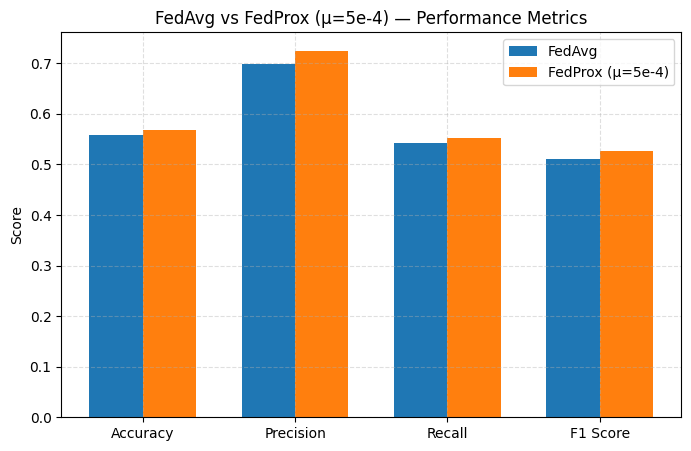

In [28]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import numpy as np

# -------------------------------------------------
# 1️⃣ Load the two best models
# -------------------------------------------------
fedavg_path = "best_global_model.pth"
fedprox_path = "best_fedprox_model_mu5.pth"

print("Loading FedAvg model...")
fedavg_model = create_resnet18(NUM_CLASSES).to(DEVICE)
fedavg_model.load_state_dict(torch.load(fedavg_path, map_location=DEVICE))
fedavg_model.eval()

print("Loading FedProx μ=5e-4 model...")
fedprox_model = create_resnet18(NUM_CLASSES).to(DEVICE)
fedprox_model.load_state_dict(torch.load(fedprox_path, map_location=DEVICE))
fedprox_model.eval()

# -------------------------------------------------
# 2️⃣ Common evaluation function
# -------------------------------------------------
crit_ce = nn.CrossEntropyLoss()

def evaluate_full(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)

            logits = model(x)
            loss = crit_ce(logits, y)

            total_loss += loss.item() * x.size(0)
            total += x.size(0)

            preds = logits.argmax(1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    acc = (all_preds == all_labels).mean()
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    loss = total_loss / total

    return {
        "acc": acc,
        "loss": loss,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "preds": all_preds,
        "labels": all_labels
    }

# -------------------------------------------------
# 3️⃣ Evaluate both models
# -------------------------------------------------
fedavg_metrics = evaluate_full(fedavg_model, holdout_loader)
fedprox_metrics = evaluate_full(fedprox_model, holdout_loader)

# -------------------------------------------------
# 4️⃣ Print comparison
# -------------------------------------------------
print("\n========= FEDAVG (Best Model) =========")
for k, v in fedavg_metrics.items():
    if k not in ("preds", "labels"):
        print(f"{k.capitalize():10}: {v:.4f}")

print("\n====== FEDPROX (μ=5e-4 Best Model) ======")
for k, v in fedprox_metrics.items():
    if k not in ("preds", "labels"):
        print(f"{k.capitalize():10}: {v:.4f}")

# -------------------------------------------------
# 5️⃣ Plot Confusion Matrices Side-by-Side
# -------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_avg = confusion_matrix(fedavg_metrics["labels"], fedavg_metrics["preds"])
cm_prox = confusion_matrix(fedprox_metrics["labels"], fedprox_metrics["preds"])

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_avg)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_prox)

disp1.plot(ax=axes[0], cmap="Blues", values_format="d")
disp2.plot(ax=axes[1], cmap="Purples", values_format="d")

axes[0].set_title("FedAvg Confusion Matrix")
axes[1].set_title("FedProx μ=5e-4 Confusion Matrix")

plt.tight_layout()
plt.show()

# -------------------------------------------------
# 6️⃣ Bar Plot Comparison (Accuracy / Precision / Recall / F1)
# -------------------------------------------------
labels = ["Accuracy", "Precision", "Recall", "F1 Score"]

fedavg_vals = [
    fedavg_metrics["acc"],
    fedavg_metrics["precision"],
    fedavg_metrics["recall"],
    fedavg_metrics["f1"]
]

fedprox_vals = [
    fedprox_metrics["acc"],
    fedprox_metrics["precision"],
    fedprox_metrics["recall"],
    fedprox_metrics["f1"]
]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, fedavg_vals, width, label="FedAvg")
plt.bar(x + width/2, fedprox_vals, width, label="FedProx (μ=5e-4)")

plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("FedAvg vs FedProx (μ=5e-4) — Performance Metrics")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


In [29]:
import torch
import random

# pick 12 random samples from the holdout loader
samples = []
labels = []

for batch_x, batch_y in holdout_loader:
    for i in range(len(batch_x)):
        samples.append(batch_x[i])
        labels.append(batch_y[i])
        if len(samples) >= 12:
            break
    if len(samples) >= 12:
        break

samples = torch.stack(samples).to(DEVICE)
labels = torch.tensor(labels).to(DEVICE)


In [35]:
!pip install captum


In [34]:
from captum.attr import IntegratedGradients

import matplotlib.pyplot as plt
import numpy as np

def generate_heatmap(model, images, title):
    model.eval()
    ig = IntegratedGradients(model)

    attributions = ig.attribute(images, target=None, n_steps=50)

    attributions = attributions.detach().cpu().numpy()

    fig, axes = plt.subplots(3, 4, figsize=(14, 9))
    fig.suptitle(title, fontsize=16)

    for i, ax in enumerate(axes.flatten()):
        if i >= len(images):
            break
        img = images[i].detach().cpu().permute(1,2,0).numpy()
        attr = np.mean(attributions[i], axis=0)

        ax.imshow(img)
        ax.imshow(attr, cmap="hot", alpha=0.5)
        ax.axis("off")

    plt.show()


Device: mps
Loaded trained model!


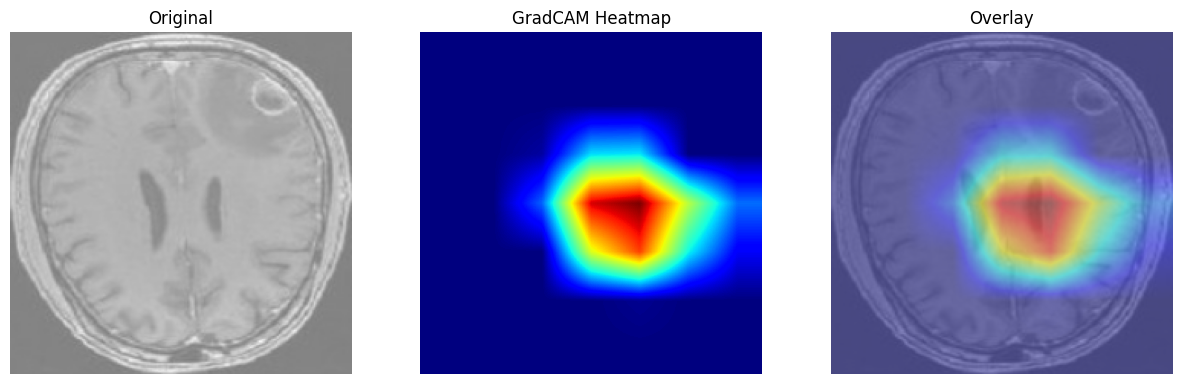

In [41]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

# ============================================================
# DEVICE
# ============================================================
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print("Device:", DEVICE)

# ============================================================
# LOAD MODEL
# ============================================================
NUM_CLASSES = len(train_dataset.classes)

model = models.resnet18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)

model.load_state_dict(torch.load("best_fedprox_model_mu5.pth", map_location=DEVICE))
model.to(DEVICE)
model.eval()

print("Loaded trained model!")

# ============================================================
# GET SAMPLE FROM HOLDOUT
# ============================================================
images, labels = next(iter(holdout_loader))

img = images[0]
label = labels[0].item()

# Image for model
img_tensor = img.unsqueeze(0).to(DEVICE)

# Image for display (undo normalization)
disp = img * 0.5 + 0.5
disp = disp.permute(1,2,0).numpy()
disp = np.clip(disp * 255, 0, 255).astype(np.uint8)

# ============================================================
# 🔥 GRADCAM HOOKS
# ============================================================
activations = []
gradients = []

layer = model.layer4[-1].conv2   # last conv layer in ResNet18

def fwd_hook(module, inp, out):
    activations.append(out.detach())

def bwd_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0].detach())

layer.register_forward_hook(fwd_hook)
layer.register_full_backward_hook(bwd_hook)   # NEW API

# ============================================================
# FORWARD + BACKWARD
# ============================================================
out = model(img_tensor)
pred_class = out.argmax(1).item()

model.zero_grad()
one_hot = torch.zeros_like(out)
one_hot[0, pred_class] = 1
out.backward(gradient=one_hot)

# ============================================================
# BUILD CAM
# ============================================================
acts = activations[-1][0]     # [C, H, W]
grads = gradients[-1][0]      # [C, H, W]

weights = grads.mean(dim=(1,2))     # [C]
cam = (weights[:, None, None] * acts).sum(dim=0)
cam = F.relu(cam)

cam = cam.cpu().numpy()

# Normalize 0–1
cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

# Resize to original image size
heatmap = cv2.resize(cam, (disp.shape[1], disp.shape[0]))
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

overlay = 0.55 * disp.astype(np.float32) + 0.45 * heatmap_color.astype(np.float32)
overlay = np.clip(overlay / 255, 0, 1)

# ============================================================
# PLOT
# ============================================================
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(disp)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("GradCAM Heatmap")
plt.imshow(heatmap, cmap='jet')
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.show()


In [70]:
transforms.Normalize([0.5]*3, [0.5]*3)


Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

In [71]:


# Same transforms used during training
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

inv_normalize = transforms.Normalize(
    mean=[-1, -1, -1],
    std=[2, 2, 2]
)




In [72]:
import torch.nn.functional as F

def generate_gradcam(model, img_tensor, target_layer, class_idx=None):
    model.eval()

    activations = None
    gradients = None

    # ---- HOOKS ----
    def fwd_hook(module, inp, out):
        nonlocal activations
        activations = out

    def bwd_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]

    # Register hooks
    h1 = target_layer.register_forward_hook(fwd_hook)
    h2 = target_layer.register_full_backward_hook(bwd_hook)

    # Forward
    logits = model(img_tensor)

    if class_idx is None:
        class_idx = logits.argmax(dim=1).item()

    loss = logits[:, class_idx]
    
    # Backward
    model.zero_grad()
    loss.backward(retain_graph=True)

    # Remove hooks
    h1.remove()
    h2.remove()

    # Compute CAM
    weights = gradients.mean(dim=(1, 2), keepdim=True)      # [C,1,1]
    cam = (weights * activations).sum(dim=1).squeeze()      # [H,W]
    cam = F.relu(cam)

    # Normalize to [0,1]
    cam -= cam.min()
    if cam.max() != 0:
        cam /= cam.max()

    return cam.detach().cpu().numpy()



In [73]:
# ------------------------------
# UNFREEZE ALL LAYERS FOR GRADCAM
# ------------------------------
for p in global_model.parameters():
    p.requires_grad = True


Found 5 correctly classified images.


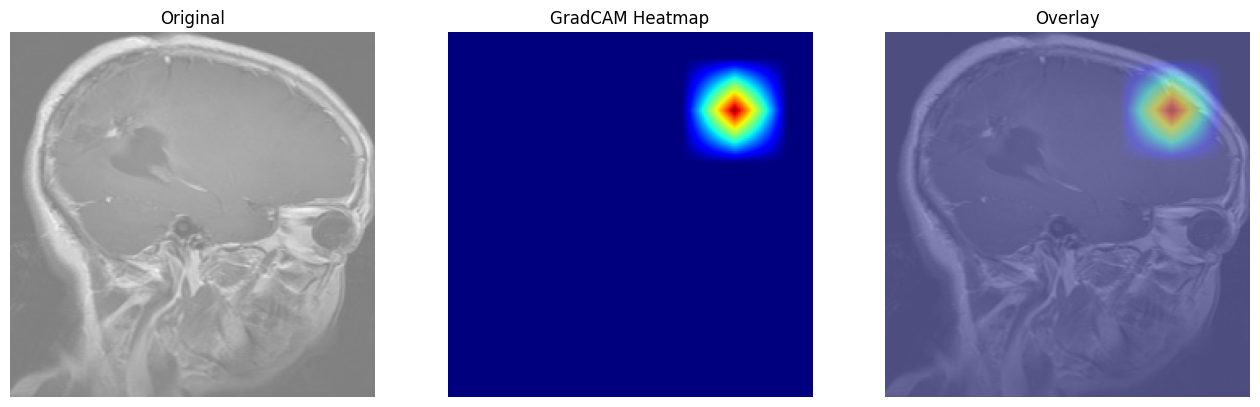

In [74]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# -------------------------------------------------------------
# 0. UNFREEZE MODEL FOR GRADCAM (REQUIRED!)
# -------------------------------------------------------------
for p in global_model.parameters():
    p.requires_grad = True
global_model.eval()

# -------------------------------------------------------------
# 1. PREPROCESS FUNCTION (match your Fed model input)
# -------------------------------------------------------------
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def tensor_to_img(t):
    """Convert normalized tensor → displayable numpy image"""
    t = t.cpu().clone().detach()
    t = t * 0.5 + 0.5          # unnormalize
    t = t.permute(1, 2, 0)     # CHW → HWC
    t = torch.clamp(t, 0, 1)
    return t.numpy()

# -------------------------------------------------------------
# 2. Extract CORRECTLY CLASSIFIED SAMPLES
# -------------------------------------------------------------
def extract_logits(raw_out):
    if isinstance(raw_out, tuple):
        return raw_out[0]
    return raw_out

def get_correct_samples(model, loader, num_samples=5):
    correct_imgs = []
    correct_labels = []
    correct_preds = []

    model.eval()

    for x, y in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        raw = model(x)
        logits = extract_logits(raw)

        preds = logits.argmax(dim=1)
        mask = preds.eq(y)  # correctly classified

        for i in range(len(x)):
            if mask[i]:
                correct_imgs.append(x[i].cpu())
                correct_labels.append(y[i].item())
                correct_preds.append(preds[i].item())

                if len(correct_imgs) >= num_samples:
                    return correct_imgs, correct_labels, correct_preds

    return correct_imgs, correct_labels, correct_preds


# -------------------------------------------------------------
# 3. GRAD-CAM HOOKS
# -------------------------------------------------------------
def generate_gradcam(model, img_tensor, target_layer):
    """Compute Grad-CAM heatmap with modern PyTorch hooks."""
    activations = []
    gradients = []

    # forward hook
    def fwd_hook(module, inp, out):
        activations.append(out)

    # backward hook (FULL backward hook works!)
    def bwd_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    # register hooks
    fwd_handle = target_layer.register_forward_hook(fwd_hook)
    bwd_handle = target_layer.register_full_backward_hook(bwd_hook)

    # forward pass
    logits = model(img_tensor)
    logits = extract_logits(logits)
    pred_class = logits.argmax(dim=1).item()

    # backward pass
    model.zero_grad()
    logits[0, pred_class].backward()

    # cleanup hooks
    fwd_handle.remove()
    bwd_handle.remove()

    # extract stored activations & grads
    acts = activations[0]          # [1, C, H, W]
    grads = gradients[0]           # [1, C, H, W]

    weights = grads.mean(dim=(2, 3), keepdim=True)  # [1, C, 1, 1]
    cam = (weights * acts).sum(dim=1).squeeze()     # [H, W]
    cam = F.relu(cam)

    cam -= cam.min()
    cam /= (cam.max() + 1e-8)

    return cam.detach().cpu().numpy()





# -------------------------------------------------------------
# 4. DISPLAY GRAD-CAM VISUALIZATIONS
# -------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import cv2

def show_gradcam(orig_tensor, cam_map):
    """
    orig_tensor: single image tensor [3, 224, 224] normalized
    cam_map: numpy array [H, W] usually 7x7
    """

    # Convert original tensor back to image (0–255)
    orig = orig_tensor.detach().cpu()
    orig = orig * 0.5 + 0.5     # unnormalize assuming mean=std=0.5
    orig = orig.permute(1, 2, 0).numpy()   # HWC
    orig = np.clip(orig, 0, 1)

    H, W, _ = orig.shape   # (224, 224, 3)

    # --- FIX: resize cam to match image size ---
    cam_resized = cv2.resize(cam_map, (W, H), interpolation=cv2.INTER_LINEAR)

    # Color map
    heatmap = plt.cm.jet(cam_resized)[..., :3]

    # Overlay
    overlay = heatmap * 0.4 + orig * 0.6

    # Plot
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(orig)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("GradCAM Heatmap")
    plt.imshow(heatmap)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(overlay)
    plt.axis("off")

    plt.show()


# -------------------------------------------------------------
# 5. GET CORRECTLY CLASSIFIED IMAGES
# -------------------------------------------------------------
correct_imgs, correct_labels, correct_preds = get_correct_samples(
    global_model,
    holdout_loader,
    num_samples=5
)

print(f"Found {len(correct_imgs)} correctly classified images.")

if len(correct_imgs) == 0:
    raise Exception("⚠️ No correctly classified images found!")

# -------------------------------------------------------------
# 6. RUN GRAD-CAM ON THE FIRST CORRECT IMAGE
# -------------------------------------------------------------
img_tensor = correct_imgs[0].unsqueeze(0).to(DEVICE)
target_layer = global_model.layer4[-1]   # ResNet18 last conv block

cam = generate_gradcam(global_model, img_tensor, target_layer)

# -------------------------------------------------------------
# 7. PLOT RESULTS
# -------------------------------------------------------------
show_gradcam(correct_imgs[0], cam)
